In [1]:
from teamwork import TeamworkPipeline, TeamworkConfig
from PIL import Image
from IPython import display
import torch
import numpy as np

In [2]:
from diffusers import FluxTransformer2DModel, GGUFQuantizationConfig
from teamwork.pipeline_flux import FluxPipeline, FluxTeamworkPipeline

In [3]:
# Optional: quantized flux
q4_transformer = FluxTransformer2DModel.from_single_file(
    "https://huggingface.co/city96/FLUX.1-dev-gguf/flux1-dev-Q4_0.gguf",
    config="black-forest-labs/FLUX.1-dev",
    subfolder="transformer",
    quantization_config=GGUFQuantizationConfig(compute_dtype=torch.bfloat16),
    torch_dtype=torch.bfloat16,
    device="cuda",
)
q4_base_pipe = FluxPipeline.from_pretrained(
    "black-forest-labs/FLUX.1-dev",
    torch_dtype=torch.bfloat16,
    transformer=q4_transformer,
).to('cuda')

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

You set `add_prefix_space`. The tokenizer needs to be converted from the slow tokenizers
`torch_dtype` is deprecated! Use `dtype` instead!


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [4]:
pipe = TeamworkPipeline.from_checkpoint(
    'samsartor/teamwork-release',
    'colocated_svbrdf_estimation_flux_512.safetensors',
    base_pipeline=q4_base_pipe,
)

In [5]:
def halfway_vectors(w, h, camera_pos, light_pos):
    surface = np.indices((h, w)) + 0.5
    surface = np.stack((
        2 * surface[1, :, :] / h - 1,
        -2 * surface[0, :, :] / w + 1,
        np.zeros((h, w), np.float32),
    ), axis=-1)

    wi = light_pos - surface
    wi /= np.linalg.norm(wi, axis=2, keepdims=True)

    wo = camera_pos - surface
    wo /= np.linalg.norm(wo, axis=2, keepdims=True)

    hw = wi + wo
    hw /= np.linalg.norm(hw, axis=2, keepdims=True)

    return hw

In [6]:
fov = 45
distance = 1/np.tan(np.deg2rad([fov])/2)
hw = halfway_vectors(512, 512, [0, 0, distance.item()], [0, 0, distance.item()])

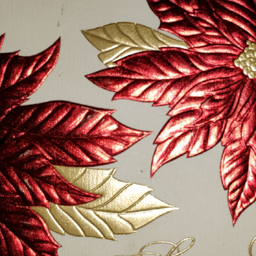

In [7]:
image = Image.open('../demo/gift_card.png')
image.resize([256, 256])

In [8]:
generated = pipe({'image': image, 'halfway': hw})

  0%|          | 0/50 [00:00<?, ?it/s]

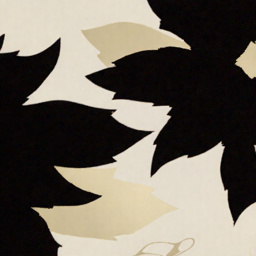

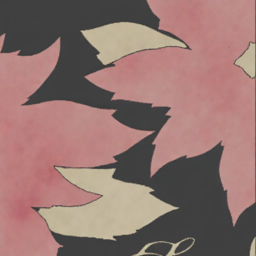

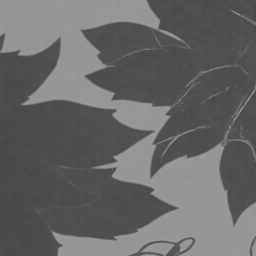

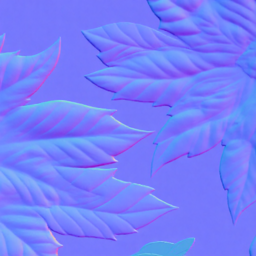

In [9]:
for name, image in generated.items():
    display.display(display.HTML(f'<h2>{name}</h2>'))
    display.display(image.resize([256, 256]))